https://keras.io/examples/timeseries/timeseries_classification_transformer/

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/DSA_features.csv')
df.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [ ]:
df.shape

(9120, 272)

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = df.drop(['activity', 'people'], axis=1)
y = df['activity']

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

n_classes = len(le.classes_)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
print (x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7296, 270) (1824, 270) (7296,) (1824,)


In [ ]:
# Standardize the features
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [ ]:
# Reshape to (samples, n_timesteps, n_features)
n_timesteps = 90  # You can choose other values if needed
n_features = 270 // n_timesteps  # This will be 3 in this case

# Reshaping the train and test data
x_train = x_train.reshape(-1, n_timesteps, n_features)
x_test = x_test.reshape(-1, n_timesteps, n_features)

In [ ]:
from keras.utils import to_categorical

# One-hot encoding
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [ ]:
print (x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7296, 90, 3) (1824, 90, 3) (7296, 19) (1824, 19)


In [ ]:
import keras
from keras import layers

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2])

model = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)
model.summary()

# callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
callbacks = [restore_best_weights=True)]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 90, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_12   │ (None, 90, 3)          │         15,363 │ input_layer_3[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_40 (Dropout)      │ (None, 90, 3)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_24    │ (None, 90, 3)          │              6 │ dropout_40[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 90, 3)          │              0 │ layer_normalization_2… │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 90, 4)          │             16 │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_41 (Dropout)      │ (None, 90, 4)          │              0 │ conv1d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 90, 3)          │             15 │ dropout_41[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_25    │ (None, 90, 3)          │              6 │ conv1d_25[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 90, 3)          │              0 │ layer_normalization_2… │
│                           │                        │                │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_13   │ (None, 90, 3)          │         15,363 │ add_25[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_25[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_43 (Dropout)      │ (None, 90, 3)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_26    │ (None, 90, 3)          │              6 │ dropout_43[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 90, 3)          │              0 │ layer_normalization_2… │
│                           │                        │                │ add_25[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_26 (Conv1D)        │ (None, 90, 4)          │             16 │ add_26[0][0]           │
├──────────────────────

 Total params: 126,211 (493.01 KB)

 Trainable params: 126,211 (493.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=128,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.4130 - loss: 1.5844 - val_accuracy: 0.4110 - val_loss: 1.6077
Epoch 2/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.4073 - loss: 1.5793 - val_accuracy: 0.4089 - val_loss: 1.5875
Epoch 3/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.4149 - loss: 1.5344 - val_accuracy: 0.4089 - val_loss: 1.5988
Epoch 4/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.3938 - loss: 1.5708 - val_accuracy: 0.4418 - val_loss: 1.4827
Epoch 5/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.4338 - loss: 1.5025 - val_accuracy: 0.4322 - val_loss: 1.5529
Epoch 6/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.4048 - loss: 1.5674 - val_accuracy: 0.4192 - val_loss: 1.6508
Epoch 7/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.4037 - loss: 1.6594 - val_accuracy: 0.3726 - val_loss: 1.8230
Epoch 8/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.4181 - loss: 1.6018 - val_accu

[1.4493082761764526, 0.5498903393745422]

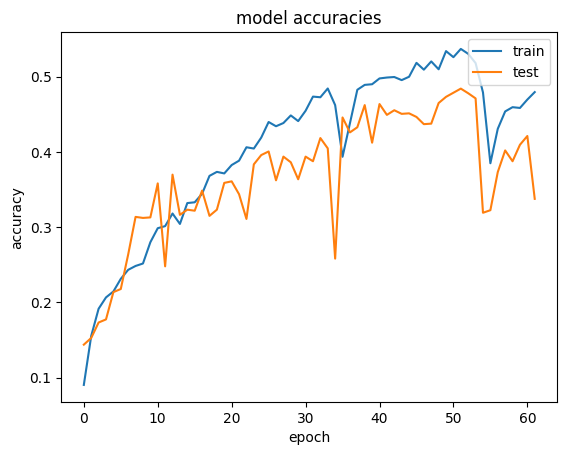

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


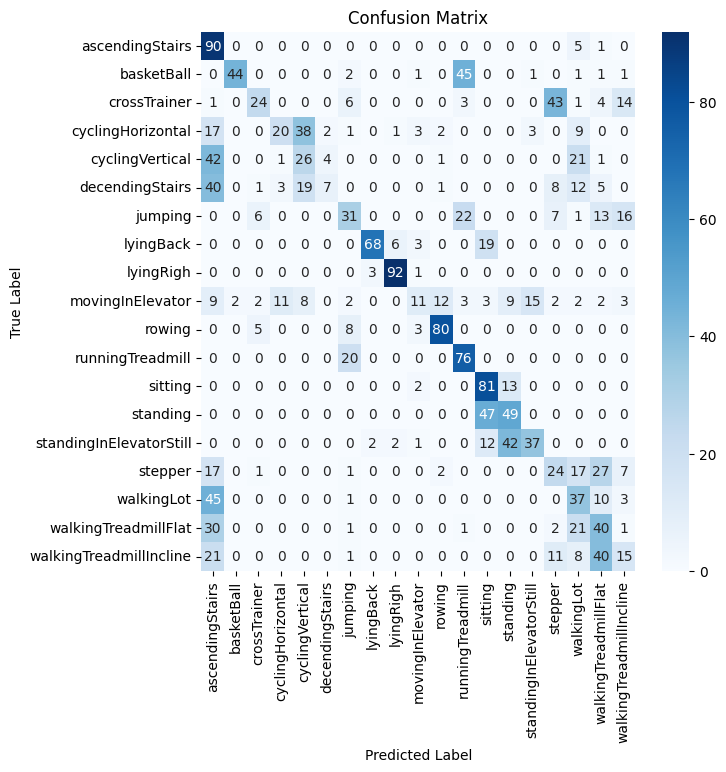

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

predict_x = model.predict(x_test)
y_pred_class= np.argmax(predict_x,axis=1)

# Convert y_test to multiclass format if it's one-hot encoded
if y_test.ndim == 2 and y_test.shape[1] > 1:  # Check if y_test is one-hot encoded
    y_test_class = np.argmax(y_test, axis=1)  # Convert to multiclass format
else:
    y_test_class = y_test  # Already in multiclass format

mat = confusion_matrix(y_test_class, y_pred_class) # Use the converted y_test_class

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(7,7))
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()